## Imports

In [1]:
import os
import pandas as pd

print("CWD:", os.getcwd())
print(f"Pandas version: {pd.__version__}")
from backtest import (
    run_backtest_mvo, run_backtest_risk_parity
)

CWD: /Users/florianochs/PycharmProjects/Alpha-Fund-Project/notebooks
Pandas version: 2.3.3


## Load data

In [2]:
df = pd.read_csv("labelled_features.csv", parse_dates=["timestamp"])
df = df.sort_values(["timestamp", "ticker"]).reset_index(drop=True)
df.head()

,ticker,timestamp,date,open,high,low,close,volume,vwap,num_trades,...,is_close,is_midday,skew_20,kurt_20,downside_vol_20,downside_ratio_20,sigma_park,sigma_ret_20,fwd_dd_log_H,label_cascade
0,SPY,2023-11-27 15:55:00+00:00,2023-11-27,454.82,455.00,454.775,454.7900,412886.0,454.8878,4270,...,1,0,-0.076097,-0.624250,0.001161,0.635834,0.000518,0.000415,-0.000792,0
1,AMZN,2023-11-27 16:00:00+00:00,2023-11-27,148.73,148.73,148.520,148.5384,453933.0,148.6113,4898,...,1,0,-0.431553,-0.039934,0.005877,0.712963,0.002284,0.001888,-0.007015,0
2,IWM,2023-11-27 16:00:00+00:00,2023-11-27,178.64,178.64,178.460,178.5000,191681.0,178.5400,1622,...,1,0,0.300257,0.172588,0.004150,0.686756,0.001289,0.001386,0.004137,0
3,PLTR,2023-11-27 16:00:00+00:00,2023-11-27,19.20,19.24,19.130,19.2150,856128.0,19.1892,3194,...,1,0,-0.973160,2.187474,0.020891,0.735974,0.005563,0.006501,-0.007051,0
4,QQQ,2023-11-27 16:00:00+00:00,2023-11-27,390.00,390.00,389.580,389.6500,355511.0,389.7821,3888,...,1,0,0.526026,-0.189274,0.001845,0.564983,0.000843,0.000741,-0.002570,0


In [3]:

print(f"Data shape: {df.shape}")
print(f"Tickers: {df['ticker'].unique()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Cascade rate: {df['label_cascade'].mean():.2%}\n")

Data shape: (177684, 72)
Tickers: ['SPY' 'AMZN' 'IWM' 'PLTR' 'QQQ' 'TSLA' 'AAPL' 'NVDA' 'AMD']
Date range: 2023-11-27 15:55:00+00:00 to 2025-11-21 15:30:00+00:00
Cascade rate: 4.37%



## Run Backtest

🚀 BACKTEST WITH MEAN-VARIANCE OPTIMIZATION (SHORT-ONLY, MARKET NEUTRAL)
Timestamps to process: 1000
Date range: 2023-11-29 12:30:00+00:00 to 2024-01-04 10:15:00+00:00
Strategy: SHORT-ONLY MVO with SPY beta=0
Top 6 stocks, cascade prob >= 0.3
Covariance lookback: 50 bars
ML Models: Separate L1 Logistic per ticker

📊 Processing timestamp 0/1000: 2023-11-29 12:30:00+00:00
📊 Processing timestamp 50/1000: 2023-11-30 10:15:00+00:00
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directional derivative for linesearch, using fallback
⚠️  Optimization failed: Positive directio

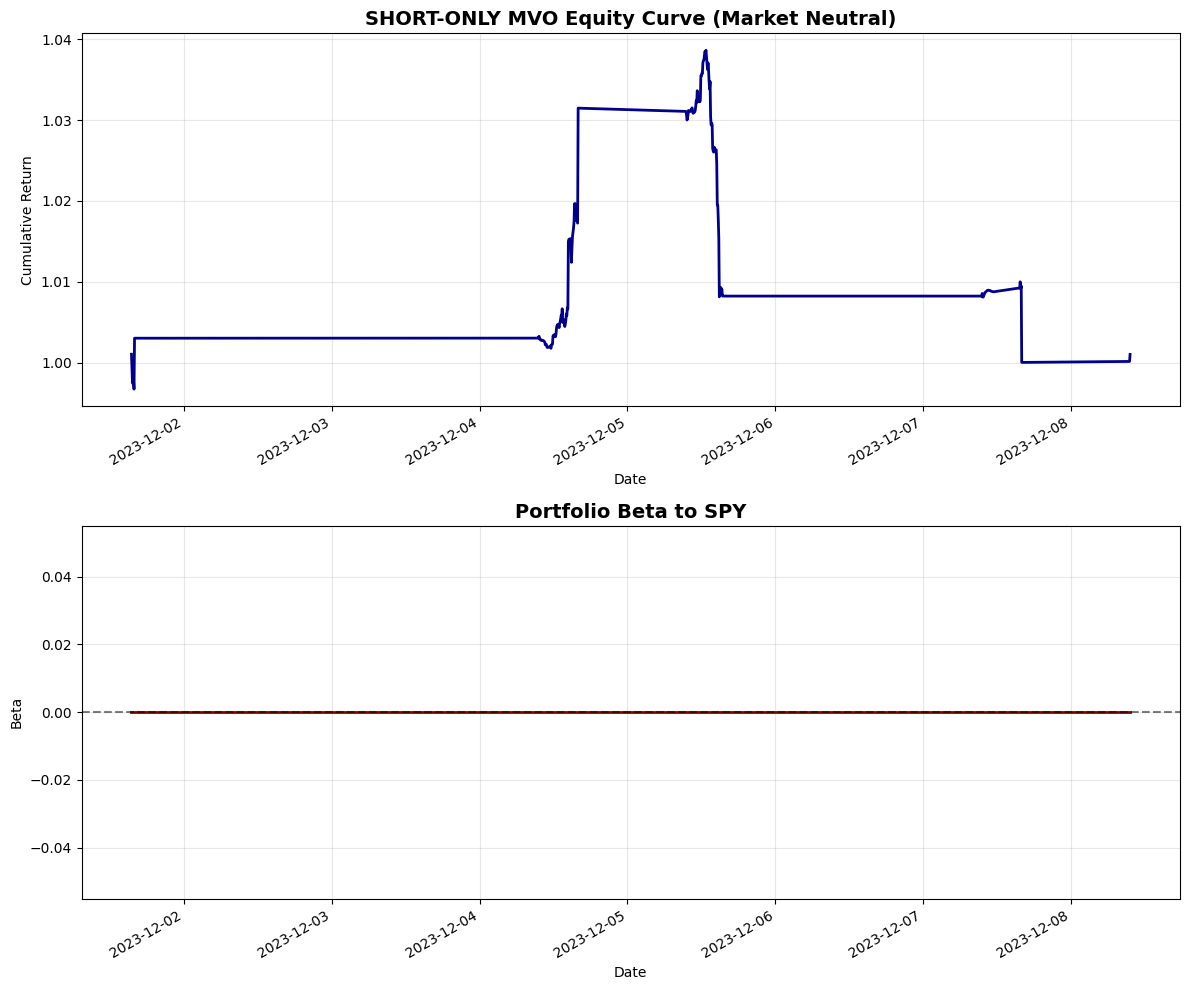


📈 PERFORMANCE STATISTICS:
cagr                     :       0.0637
ann_vol                  :       0.2579
sharpe                   :       0.2468
max_dd                   :      -0.0372
avg_gross_exposure       :       2.3666
avg_net_exposure         :      -1.0673
avg_num_positions        :       3.0000
avg_portfolio_beta       :       0.0000
max_abs_beta             :       0.0000


In [4]:
res = run_backtest_mvo(
    df=df,
    risk_col="rv_20",
    top_n_tickers=6,
    lookback_bars=8,
    start_timestamp_index=100,  # Skip first 100 timestamps for warm-up
    max_timestamps=1000
)

## Inspect outputs

### Exact results

In [7]:
port_ret = res["returns"]
equity = res["equity_curve"]
stats = res["stats"]
weights = res["weights"]

print("\n📊 PERFORMANCE STATISTICS:")
print("=" * 70)
for k, v in stats.items():
    print(f"{k:30s}: {v:>10.4f}")
print("=" * 70)


📊 PERFORMANCE STATISTICS:
cagr                          :     0.0637
ann_vol                       :     0.2579
sharpe                        :     0.2468
max_dd                        :    -0.0372
avg_gross_exposure            :     2.3666
avg_net_exposure              :    -1.0673
avg_num_positions             :     3.0000
avg_portfolio_beta            :     0.0000
max_abs_beta                  :     0.0000


### Inspect portfolio exposure over time

In [8]:
exposure_stats = weights.groupby("timestamp").agg({
    "weight": ["sum", lambda x: x.abs().sum(), "count"]
})
exposure_stats.columns = ["net_exposure", "gross_exposure", "num_positions"]

print("\nExposure Statistics:")
print(exposure_stats.describe())


Exposure Statistics:
       net_exposure  gross_exposure  num_positions
count    170.000000      170.000000          170.0
mean      -1.067279        2.366561            3.0
std        1.913478        1.336941            0.0
min      -10.900449        1.008536            3.0
25%       -2.169207        1.430946            3.0
50%       -1.050672        1.951131            3.0
75%       -0.261235        3.080949            3.0
max        5.634404       10.900449            3.0


### Inspect long/short breakdown

In [9]:
weights["position_type"] = weights["weight"].apply(
    lambda x: "LONG" if x > 0 else ("SHORT" if x < 0 else "NEUTRAL")
)

print("\nPosition Type Breakdown:")
print(weights["position_type"].value_counts())
print(f"\nAverage long weight: {weights[weights['weight'] > 0]['weight'].mean():.4f}")
print(f"Average short weight: {weights[weights['weight'] < 0]['weight'].mean():.4f}")


Position Type Breakdown:
position_type
SHORT    427
LONG      83
Name: count, dtype: int64

Average long weight: 1.3306
Average short weight: -0.6836


In [10]:
# Sample of weights
print("\nSample weights from backtest:")
weights.head(20)
weights


Sample weights from backtest:


,ticker,weight,prob_cascade,expected_return,beta_to_spy,timestamp,position_type
0,AMZN,-0.500000,0.500000,-0.012609,-1.074964,2023-12-01 15:30:00+00:00,SHORT
1,NVDA,-0.500000,0.500000,-0.016207,-18.725935,2023-12-01 15:30:00+00:00,SHORT
2,SPY,-9.900449,0.000000,0.000000,1.000000,2023-12-01 15:30:00+00:00,SHORT
3,AMZN,-0.500000,0.500000,-0.012609,-0.985845,2023-12-01 15:35:00+00:00,SHORT
4,NVDA,-0.500000,0.500000,-0.016207,-6.018473,2023-12-01 15:35:00+00:00,SHORT
...,...,...,...,...,...,...,...
505,NVDA,-0.500000,0.371735,-0.009503,0.016438,2023-12-08 09:30:00+00:00,SHORT
506,SPY,-3.565697,0.000000,0.000000,1.000000,2023-12-08 09:30:00+00:00,SHORT
507,AMZN,-0.500000,0.500000,-0.012609,2.731459,2023-12-08 09:35:00+00:00,SHORT
508,NVDA,-0.500000,0.370741,-0.006257,10.537350,2023-12-08 09:35:00+00:00,SHORT
